In [1]:
#--Simulation settings--
num_rounds = 50 # Number of communication rounds
num_devices = 10 # Number of devices
SNR = 1 #Signal-to-Noise ratio in linear scale (-1 means no noise)
bs = 50 # Batch size for local training at devices
ep = 2 # Number of local epochs before communication round
filename = "SNR-1-devices-10-gradient"

In [44]:
#--Load MNIST dataset--
import tensorflow as tf
import time
import numpy as np
import henrikFL

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255, x_test/255

num_samples = len(x_train)

#Split dataset into shards
samples_per_shard = int(num_samples/num_devices)
x_train_shards = []
y_train_shards = []
for i in range(num_devices):
    x_train_shard = x_train[i*samples_per_shard:(i+1)*samples_per_shard]
    x_train_shards.append(x_train_shard)
    y_train_shard = y_train[i*samples_per_shard:(i+1)*samples_per_shard]
    y_train_shards.append(y_train_shard)

print("Dataset loaded.")

Dataset loaded.


In [3]:
#--Set up DNN models--
model_template = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

model_list = []

#Create user device models and global model
global_model = tf.keras.models.clone_model(model_template)
for i in range(num_devices):
    model_list.append(tf.keras.models.clone_model(model_template))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#Compile all models to initiate weights
for model in model_list:
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

#Broadcast global model to all user devices
global_weights = global_model.get_weights()
for model in model_list:
    model.set_weights(global_weights)

In [46]:
#--Perform FL--
acc_history = []
for r in range(num_rounds):
    print("Communication round " + str(r+1) + "/" + str(num_rounds))
    start = time.time()
    #Train using local dataset
    for d in range(num_devices): #TODO: Parallelize
        model_list[d].fit(x_train_shards[d], y_train_shards[d], batch_size=bs, epochs=ep, verbose=0)
    #Calculate weight updates
    new_weights = []
    weight_updates = []
    for d in range(num_devices):
        new_weights.append(model_list[d].get_weights())
        weight_updates.append(new_weights[d]) #Just to initiate shape
        for l in range(len(weight_updates[d])):
            weight_updates[d][l] = new_weights[d][l] - global_weights[l]
    #Normalize the updates
    weight_updates, mean, var = henrikFL.normalize_weights(weight_updates)
    #Sum the weight updates
    average_update = weight_updates[0] #Just to initiate shape
    for d in range(num_devices):
        if d == 0:
            continue
        for l in range(len(average_update)):
            average_update[l] = average_update[l] + weight_updates[d][l]
    
    #When performing averaging, noise is added. I follow BAA for noise power
    for l in range(len(average_update)):
        if SNR != -1:
            for element in np.nditer(average_update[l], op_flags = ['readwrite']):
                element[...] = element + np.random.normal(0, np.abs(element)/SNR)
        average_update[l] = average_update[l]/num_devices
    
    #Update global model
    new_global = global_weights #Just to initiate shape
    for l in range(len(new_global)):
        new_global[l] = global_weights[l] + average_update[l]
    #Broadcast global model to user devices
    for model in model_list:
        model.set_weights(new_global)
    global_weights = new_global
    #Logging
    acc_history.append(model_list[0].evaluate(x_test, y_test, verbose=0)[1])
    print("Current test dataset accuracy: ", acc_history[-1])
    print(str(int(time.time()-start)) + " seconds elapsed\n")

Communication round 1/1
Weight update mean:  -0.014954791776835919
Weight update variance:  0.007288389513269067
Current test dataset accuracy:  0.1166
11 seconds elapsed



In [47]:
#De-normalize the average weight update
def test():
    a = 1
    b = 2
    c = 3
    return a, b, c

d, e, f = test()
print("vars: ", d, e, f)

#for d in range(num_devices):
#    for l in range(num_layers):
#        for weight in np.nditer(weight_updates[d][l], op_flags = ['readwrite']):
#            weight[...] = (weight-mean)/np.sqrt(variance)

vars:  1 2 3


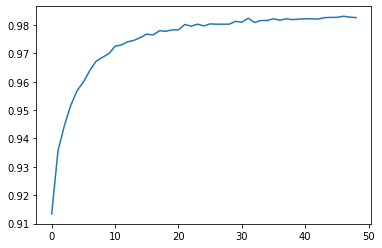

In [37]:
#--Plot accuracy--
import matplotlib.pyplot as plt
start = 0
end = -1
fig = plt.figure()
plt.plot(range(len(acc_history[start:end])), acc_history[start:end])
plt.savefig("./plots/"+filename+".png", format='png')

In [6]:
#--Store history--
np_history = np.asarray(acc_history)
np_history.tofile("./acc_history/"+filename+".txt", sep=',')

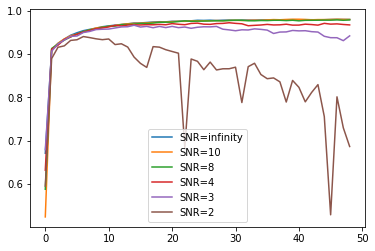

In [7]:
#--Comparative plot--
#Get history
import numpy as np
import matplotlib.pyplot as plt
filenames = []
filenames.append("SNR-infinity-devices-10")
filenames.append("SNR-10-devices-10")
filenames.append("SNR-8-devices-10")
filenames.append("SNR-4-devices-10")
filenames.append("SNR-3-devices-10")
filenames.append("SNR-2-devices-10")
labels = []
labels.append("SNR=infinity")
labels.append("SNR=10")
labels.append("SNR=8")
labels.append("SNR=4")
labels.append("SNR=3")
labels.append("SNR=2")
histories = []
for i in range(len(filenames)):
    histories.append(np.fromfile("./acc_history/"+filenames[i]+".txt", sep=","))
#Plot
start = 0
end = -1
fig = plt.figure()
for i in range(len(filenames)):
    plt.plot(range(len(histories[i][start:end])), histories[i][start:end], label=labels[i])
plt.legend()
#plt.savefig("./plots/"+filename+".png", format='png')

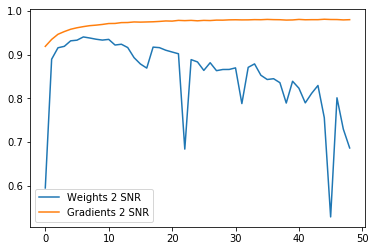

In [8]:
#--Comparative plot 2--
#Get history
import numpy as np
import matplotlib.pyplot as plt
filenames = []
filenames.append("SNR-2-devices-10")
filenames.append("SNR-2-devices-10-gradient")
labels = []
labels.append("Weights 2 SNR")
labels.append("Gradients 2 SNR")
histories = []
for i in range(len(filenames)):
    histories.append(np.fromfile("./acc_history/"+filenames[i]+".txt", sep=","))
#Plot
start = 0
end = -1
fig = plt.figure()
for i in range(len(filenames)):
    plt.plot(range(len(histories[i][start:end])), histories[i][start:end], label=labels[i])
plt.legend()
#plt.savefig("./plots/"+filename+".png", format='png')